In [24]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

**Util function**

In [25]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'c_elegans' / 'c_elegans_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['batch', 'cell_type'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cell_type', 
                    'size_factor_covariate': 'batch',
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [26]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_c_elegans_whole_genome/bd5c1915-ea4d-4428-9aeb-99d3346bcc55/checkpoints/epoch_19.ckpt"

In [27]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [28]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [29]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/GUIDED_MULTILAB_C_ELEGANS/169042b9-7ce5-4073-aa71-48e19311fe10/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [30]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.5531, -0.6685, -0.5653,  ..., -0.1101, -0.8070, -1.4514],
        [-2.5990,  0.7204,  0.1650,  ..., -1.2125,  0.3634, -1.1359],
        [ 1.3781, -0.4103,  1.0253,  ...,  2.0336, -0.0504, -0.0478],
        ...,
        [ 1.5036, -2.2991,  0.8121,  ..., -3.4769, -1.6782, -0.0274],
        [-0.4429,  0.5166, -1.0473,  ...,  0.9646,  0.6653, -1.1085],
        [-0.1089,  1.7367, -1.5817,  ..., -2.0138,  0.7472,  1.0578]],
       device='cuda:0', requires_grad=True)


Initializations

In [31]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 2, 'batch': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=17747, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

**Check the data**

In [32]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [33]:
adata_original.X

array([[ 7.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [11.,  0.,  5., ...,  0.,  0.,  1.],
       ...,
       [18.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [20.,  0.,  1., ...,  0.,  0.,  0.]], dtype=float32)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


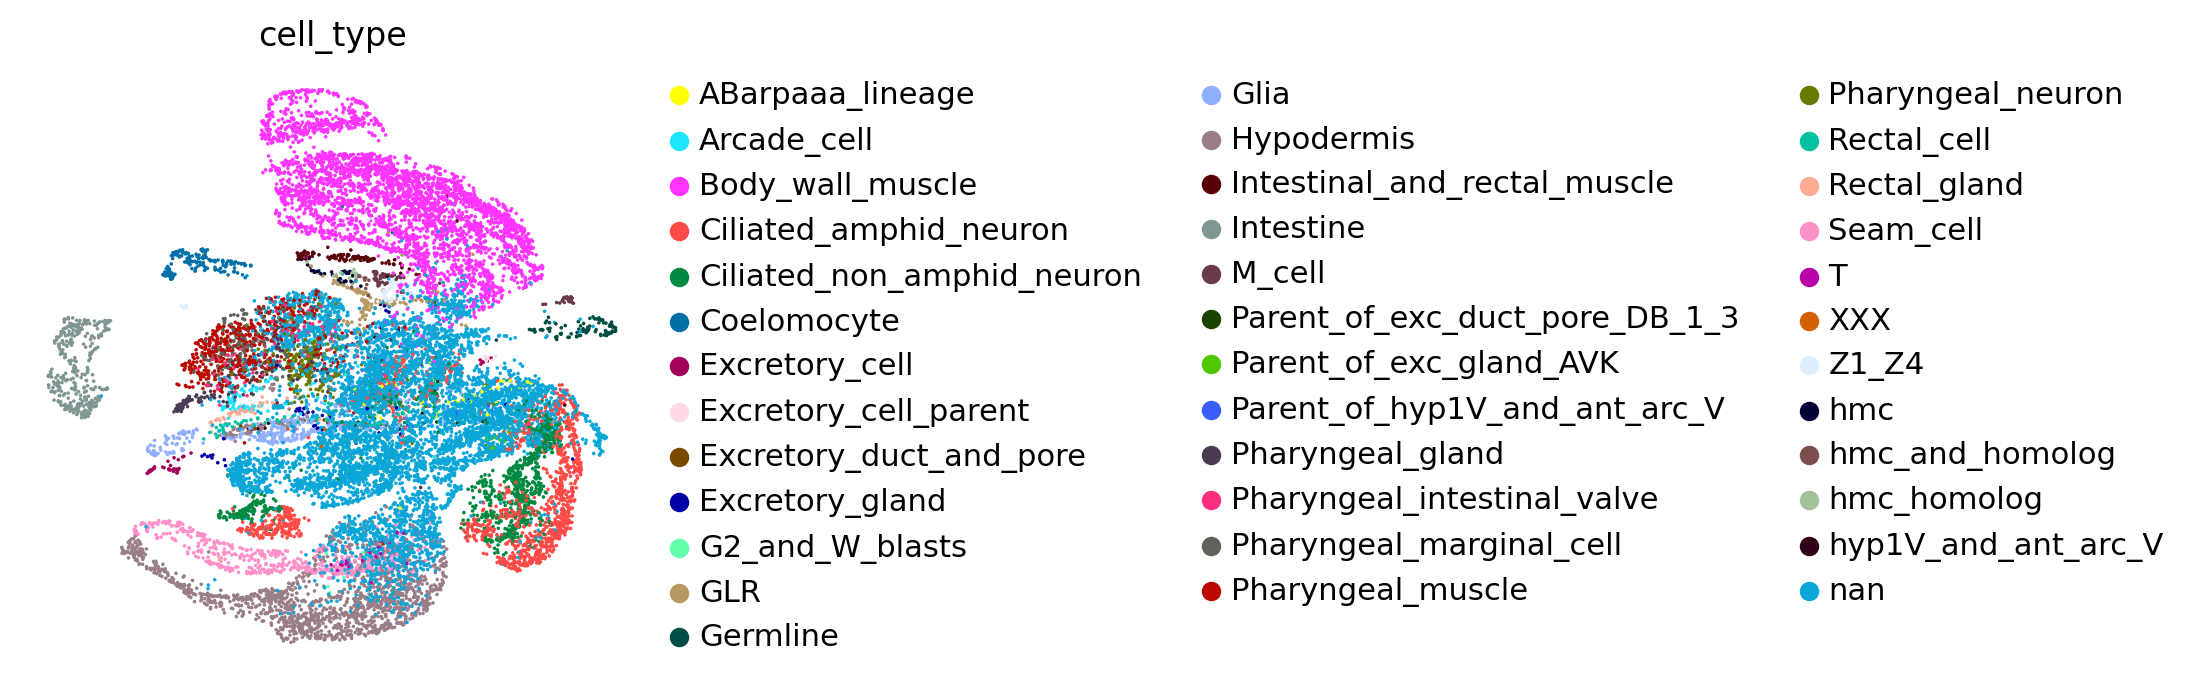

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


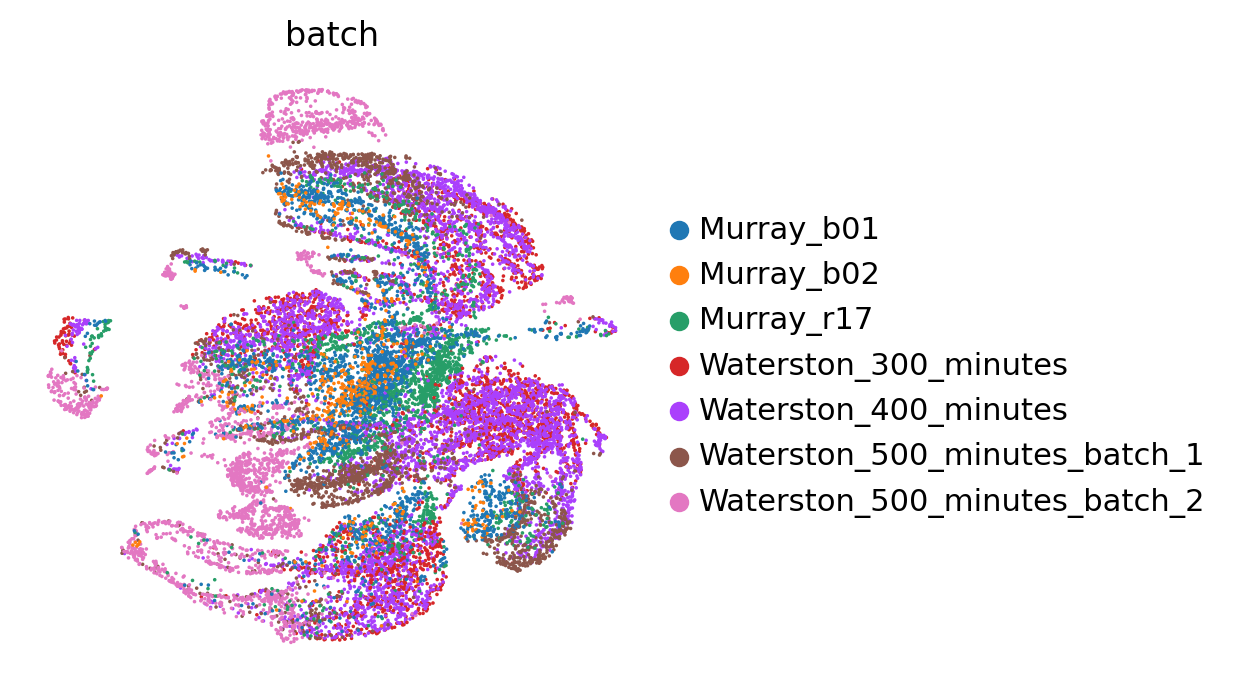

In [34]:
sc.pl.umap(adata_original, color="cell_type")
sc.pl.umap(adata_original, color="batch")

# COMBINATION OF CONDITIONS 

In [35]:
generative_model.guidance_weights

{'cell_type': 2, 'batch': 2}

In [36]:
dataset.id2cov["cell_type"]

{'ABarpaaa_lineage': 0,
 'Arcade_cell': 1,
 'Body_wall_muscle': 2,
 'Ciliated_amphid_neuron': 3,
 'Ciliated_non_amphid_neuron': 4,
 'Coelomocyte': 5,
 'Excretory_cell': 6,
 'Excretory_cell_parent': 7,
 'Excretory_duct_and_pore': 8,
 'Excretory_gland': 9,
 'G2_and_W_blasts': 10,
 'GLR': 11,
 'Germline': 12,
 'Glia': 13,
 'Hypodermis': 14,
 'Intestinal_and_rectal_muscle': 15,
 'Intestine': 16,
 'M_cell': 17,
 'Parent_of_exc_duct_pore_DB_1_3': 18,
 'Parent_of_exc_gland_AVK': 19,
 'Parent_of_hyp1V_and_ant_arc_V': 20,
 'Pharyngeal_gland': 21,
 'Pharyngeal_intestinal_valve': 22,
 'Pharyngeal_marginal_cell': 23,
 'Pharyngeal_muscle': 24,
 'Pharyngeal_neuron': 25,
 'Rectal_cell': 26,
 'Rectal_gland': 27,
 'Seam_cell': 28,
 'T': 29,
 'XXX': 30,
 'Z1_Z4': 31,
 'hmc': 32,
 'hmc_and_homolog': 33,
 'hmc_homolog': 34,
 'hyp1V_and_ant_arc_V': 35,
 'nan': 36}

In [37]:
dataset.id2cov["batch"]

{'Murray_b01': 0,
 'Murray_b02': 1,
 'Murray_r17': 2,
 'Waterston_300_minutes': 3,
 'Waterston_400_minutes': 4,
 'Waterston_500_minutes_batch_1': 5,
 'Waterston_500_minutes_batch_2': 6}

In [38]:
pd.crosstab(adata_original.obs.cell_type, adata_original.obs.batch)

batch                           Murray_b01  Murray_b02  Murray_r17  \
cell_type                                                            
ABarpaaa_lineage                         5           2           9   
Arcade_cell                             30          11           5   
Body_wall_muscle                       404         108         240   
Ciliated_amphid_neuron                 164          43         105   
Ciliated_non_amphid_neuron             126          25          87   
Coelomocyte                             27           4          18   
Excretory_cell                           3           2           4   
Excretory_cell_parent                    1           0           2   
Excretory_duct_and_pore                  0           0           1   
Excretory_gland                          9           5           6   
G2_and_W_blasts                          0           0           0   
GLR                                     18           5           5   
Germline                                30           0          18   
Glia                                    67          26          30   
Hypodermis                             111          27          87   
Intestinal_and_rectal_muscle            12           1           7   
Intestine                               18           1          42   
M_cell                                  10           2           4   
Parent_of_exc_duct_pore_DB_1_3           0           0           2   
Parent_of_exc_gland_AVK                  2           1           0   
Parent_of_hyp1V_and_ant_arc_V            0           0           1   
Pharyngeal_gland                        16          12           9   
Pharyngeal_intestinal_valve             10           3          17   
Pharyngeal_marginal_cell                32           6          20   
Pharyngeal_muscle                       71          15          51   
Pharyngeal_neuron                       32          10          38   
Rectal_cell                              8           2           3   
Rectal_gland                             6          10           0   
Seam_cell                               37           5          22   
T                                        0           0           0   
XXX                                      1           0           1   
Z1_Z4                                   11           8           6   
hmc                                     10           0           3   
hmc_and_homolog                          2           2           1   
hmc_homolog                              7           0           3   
hyp1V_and_ant_arc_V                      2           1           2   
nan                                   1180         284        1014   

batch                           Waterston_300_minutes  Waterston_400_minutes  \
cell_type                                                                      
ABarpaaa_lineage                                   18                     17   
Arcade_cell                                         0                      5   
Body_wall_muscle                                  638                   1196   
Ciliated_amphid_neuron                            150                    382   
Ciliated_non_amphid_neuron                        130                    271   
Coelomocyte                                         5                     37   
Excretory_cell                                      4                      8   
Excretory_cell_parent                               2                      8   
Excretory_duct_and_pore                             0                     11   
Excretory_gland                                     0                      7   
G2_and_W_blasts                                     1                      9   
GLR                                                27                     51   
Germline                                           18                     22   
Glia                                               11                

In [39]:
# Pick condition 
covariates_cell_type = 'Germline'
covariates_batch = 'Murray_r17'

condition_id_clus = dataset.id2cov["cell_type"][covariates_cell_type]
condition_id_batch = dataset.id2cov["batch"][covariates_batch]

adata_cond = adata_original[np.logical_and(adata_original.obs.cell_type==covariates_cell_type, 
                                           adata_original.obs.batch==covariates_batch)]
n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_clus*torch.ones(n_to_generate).long(), 
           "batch": condition_id_batch*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_type for n in range(n_to_generate)], 
           "batch": [covariates_batch for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [43]:
generative_model.denoising_model.guided_conditioning=True

In [44]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="batch",
                                        conditioning_covariates=["cell_type", "batch"],
                                        covariate_indices=classes, 
                                        log_size_factor=None)

X_generated = X_generated.to("cpu")

adata_generated = sc.AnnData(X=X_generated.numpy())

In [45]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["cell_type", "batch"])

In [46]:
X_generated.sum(1).max()

tensor(6948.)

In [47]:
X.sum(1).max()

tensor(126183.)

In [48]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

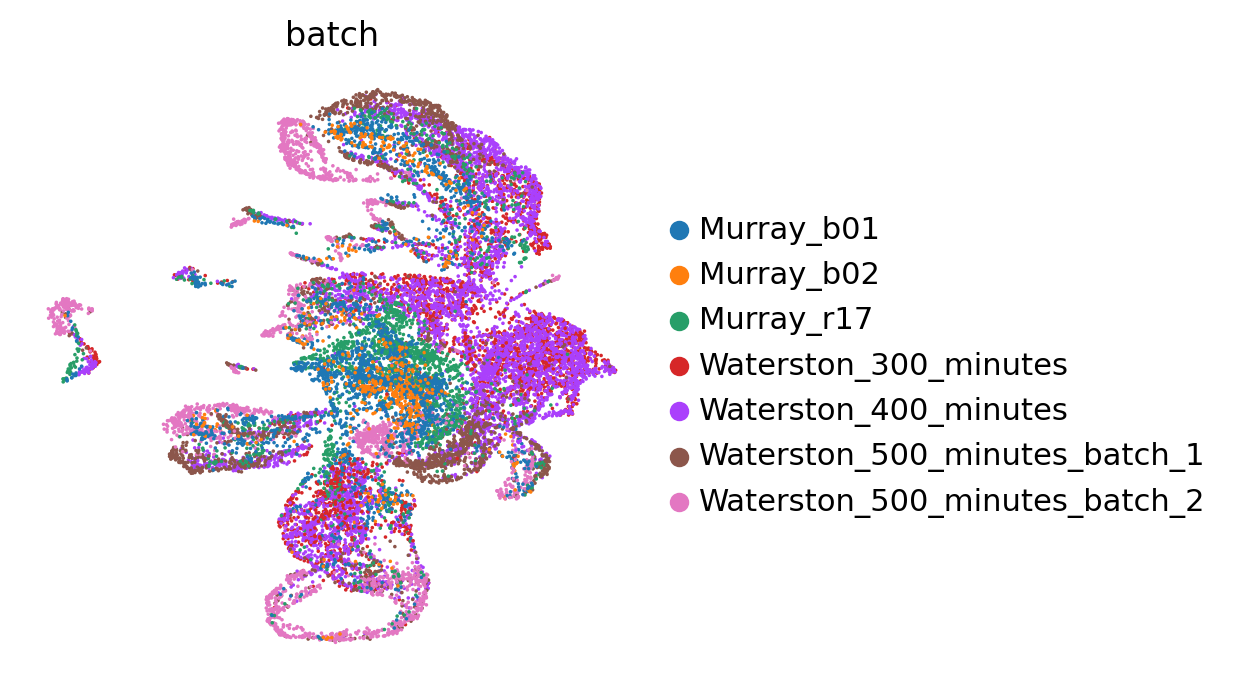

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

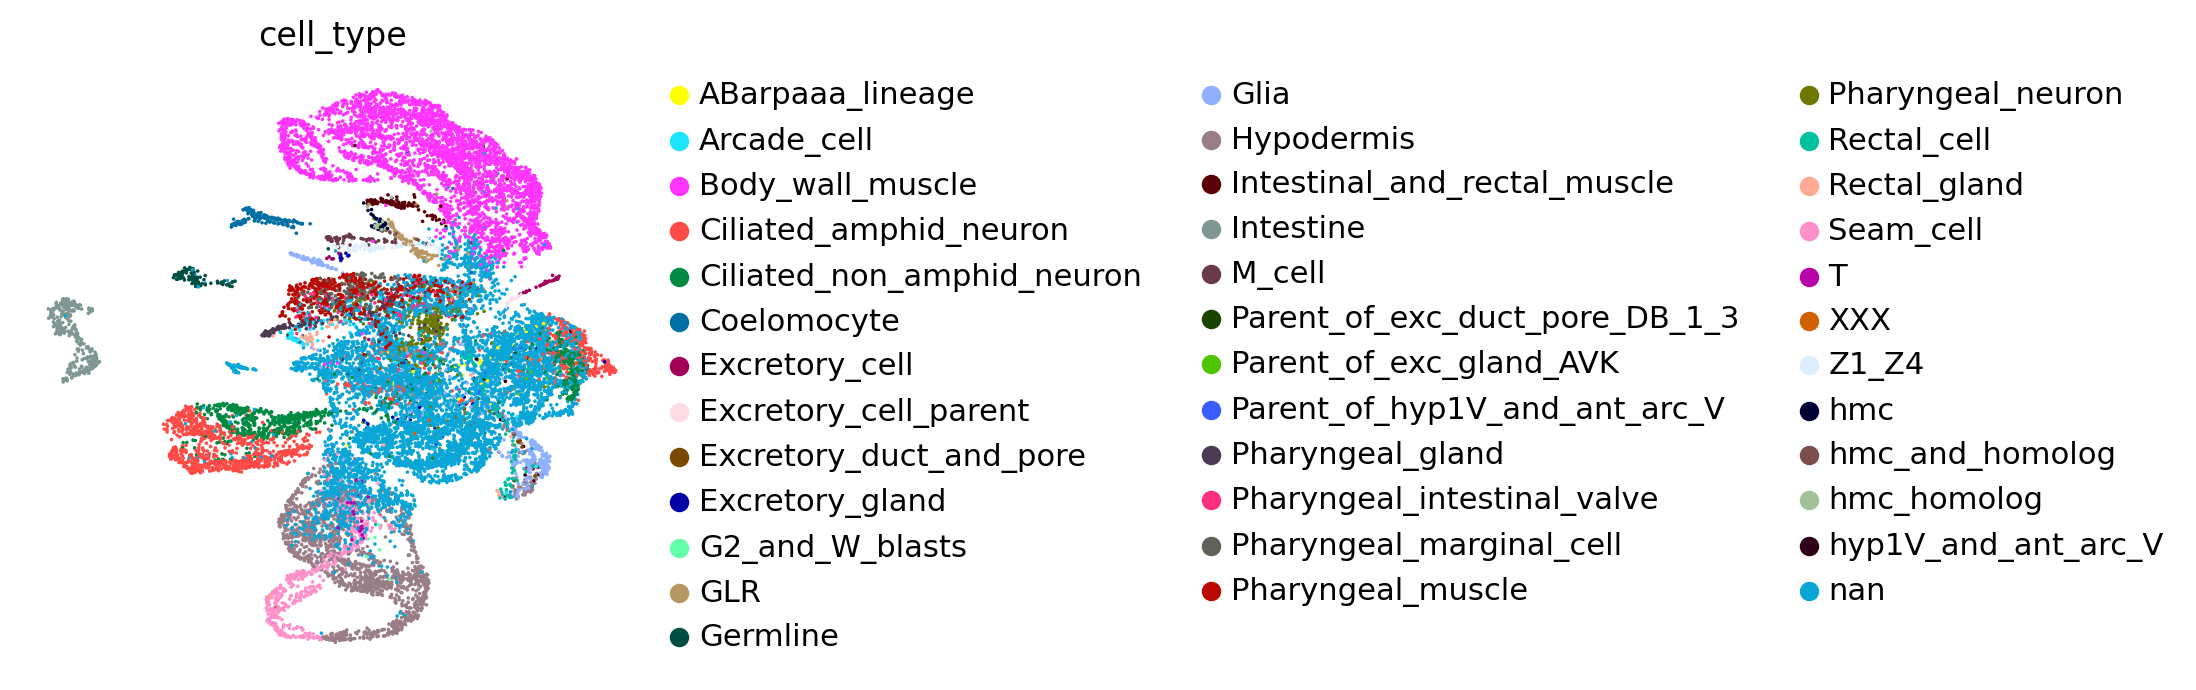

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


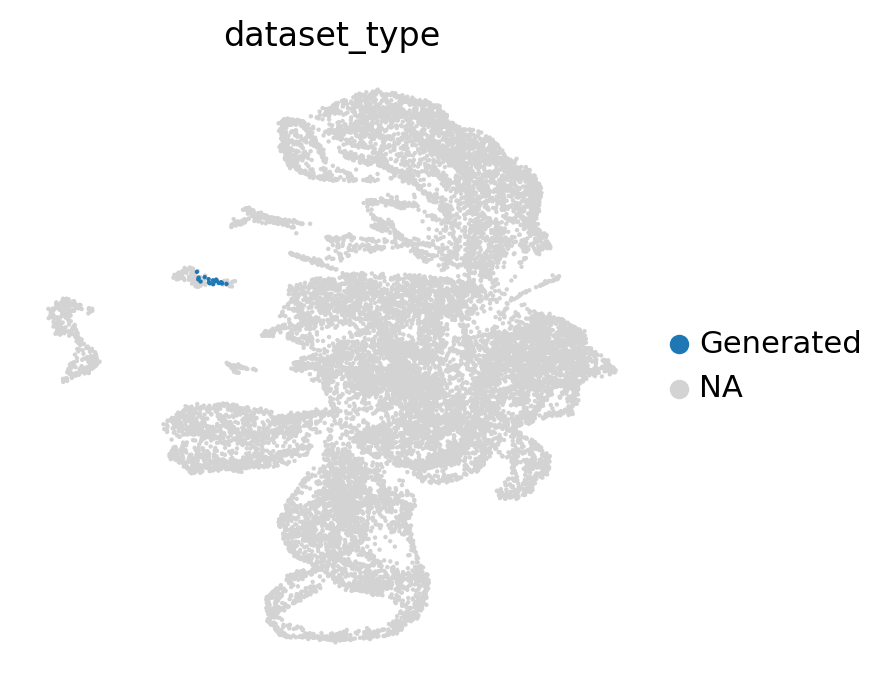

In [49]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="batch")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/pytho

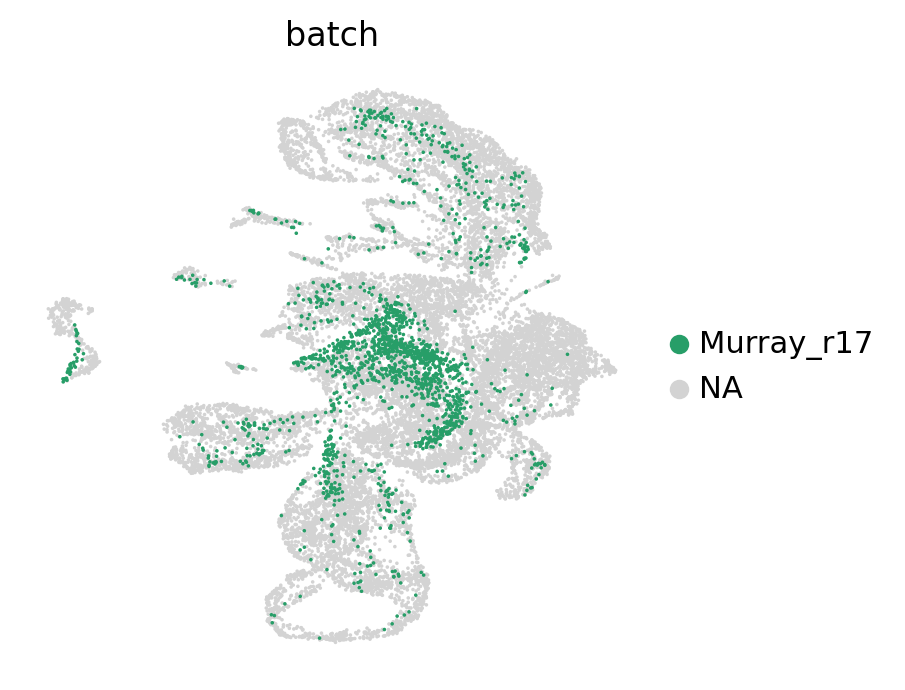

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/pytho

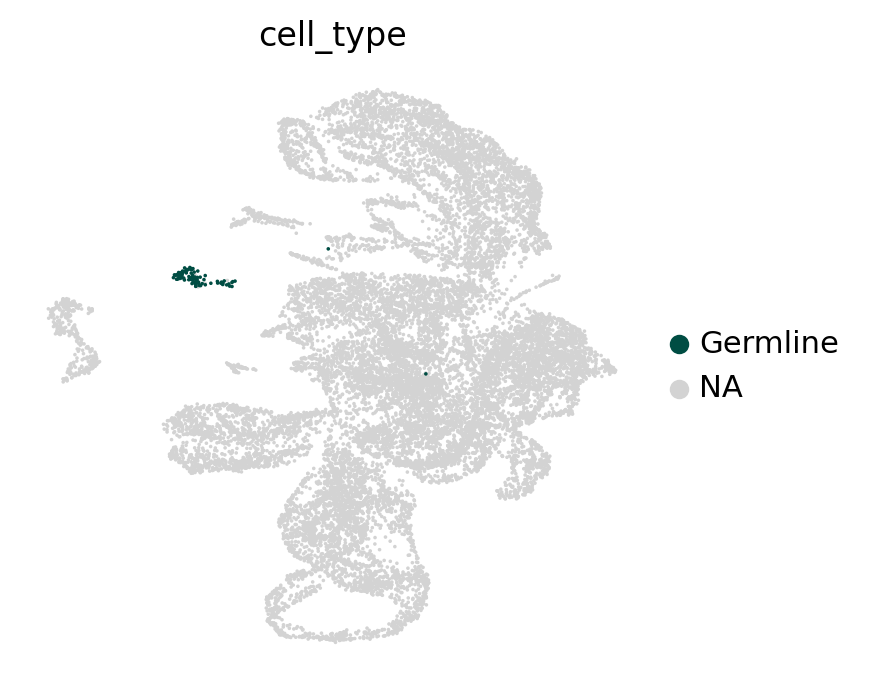

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


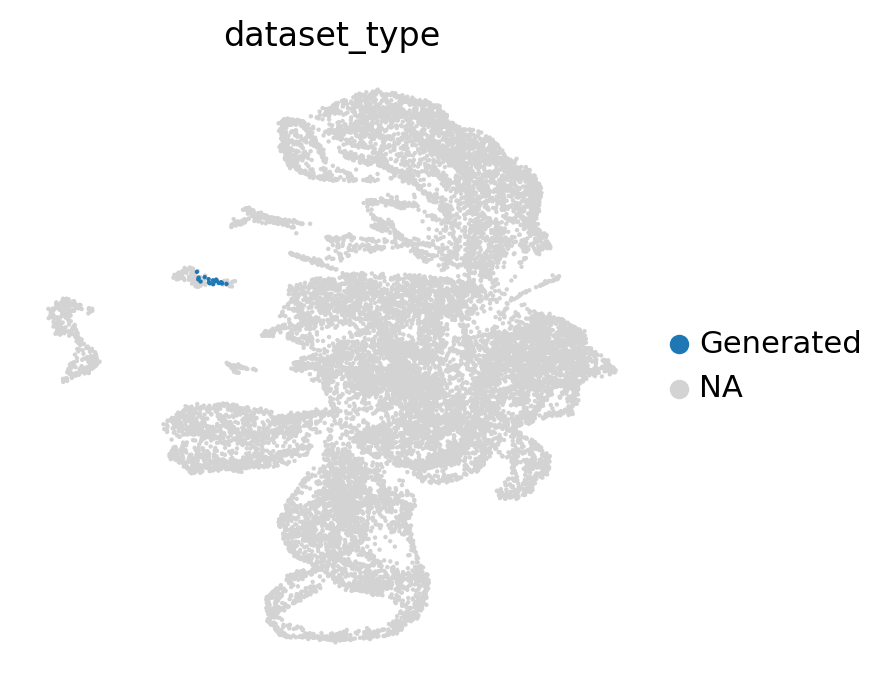

In [50]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="batch", groups="Murray_r17")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="cell_type", groups="Germline")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - cell_type

In [104]:
# Pick condition 
covariates_cell_type = 'Ciliated_amphid_neuron'

condition_id_clus = dataset.id2cov["cell_type"][covariates_cell_type]

adata_cond = adata_original[adata_original.obs.cell_type==covariates_cell_type]

n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_clus*torch.ones(n_to_generate).long(), 
           "batch": condition_id_batch*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_type for n in range(n_to_generate)], 
           "batch": [covariates_batch for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [105]:
X_generated_cell_type = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="batch",
                                        conditioning_covariates=["cell_type"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

adata_generated_cell_type = sc.AnnData(X=X_generated_cell_type.cpu().numpy())

In [106]:
adata_merged_cell_type = join_real_generated(adata_original, adata_generated_cell_type, True, classes_str, ["cell_type", "batch"])

In [107]:
sc.pp.neighbors(adata_merged_cell_type)
sc.tl.umap(adata_merged_cell_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

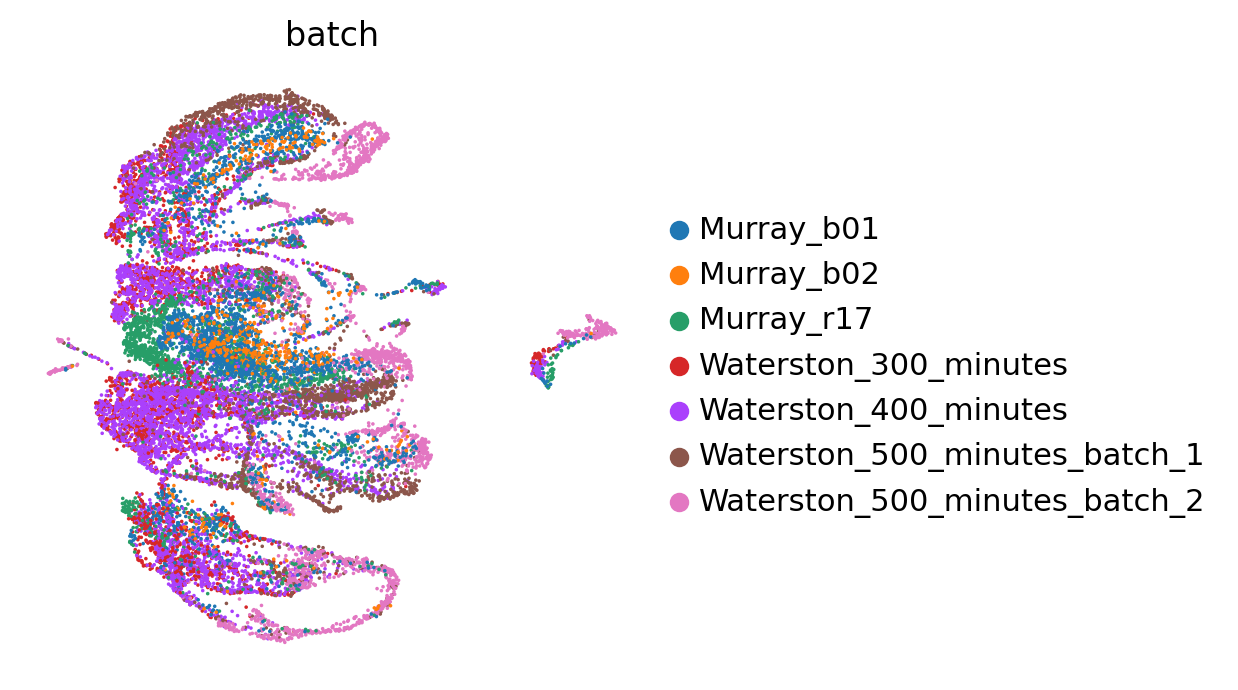

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

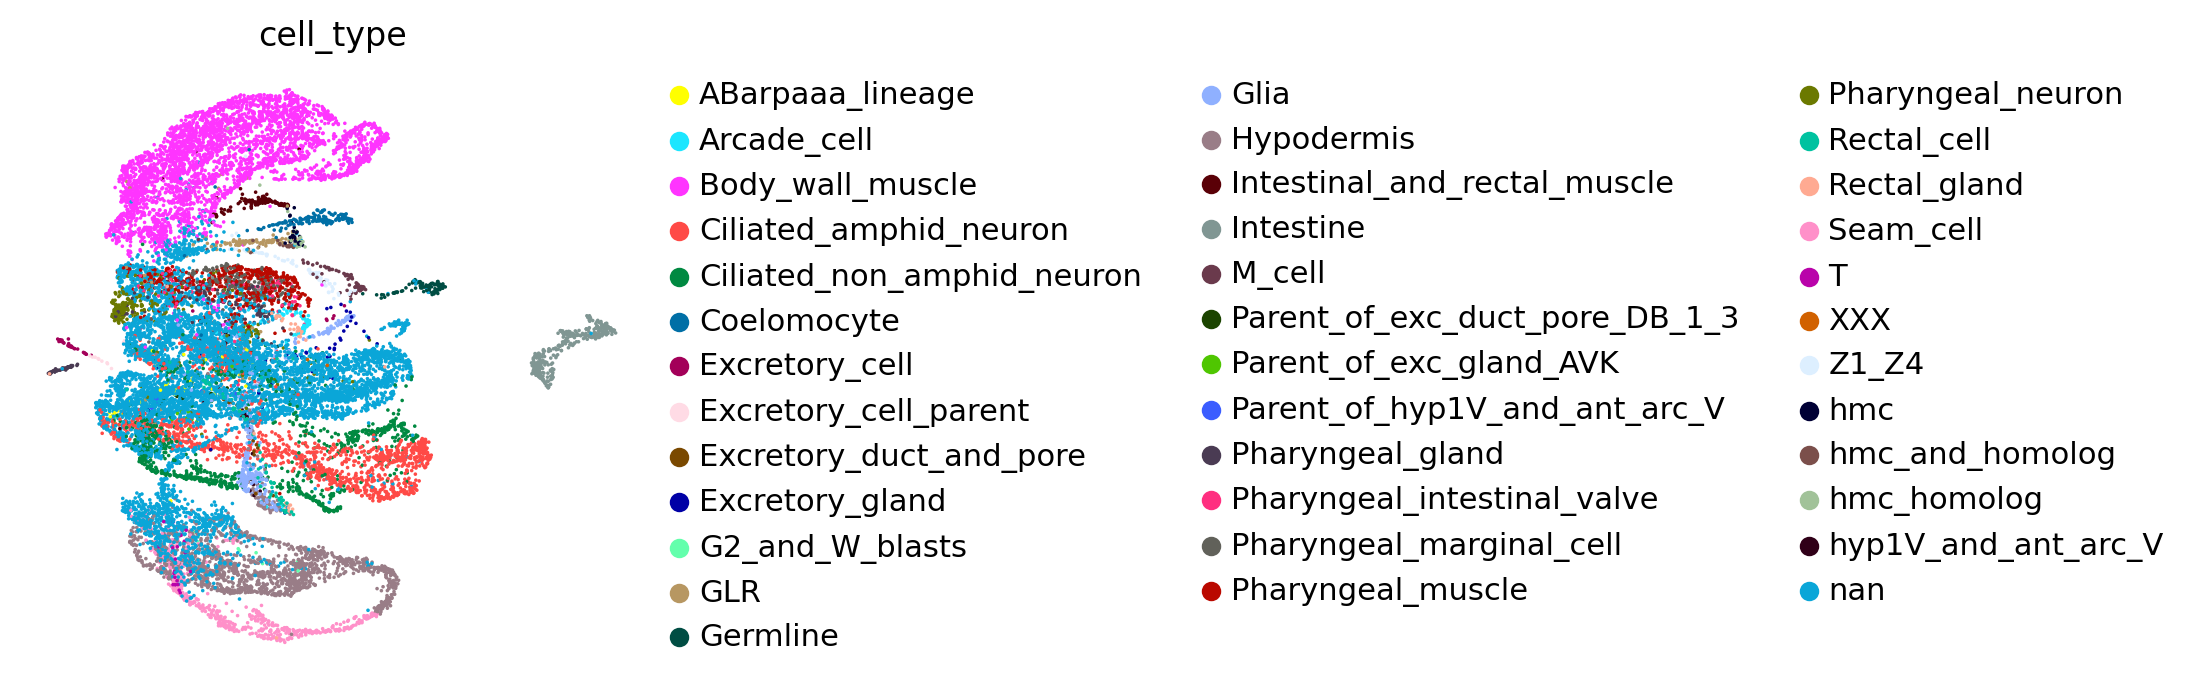

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


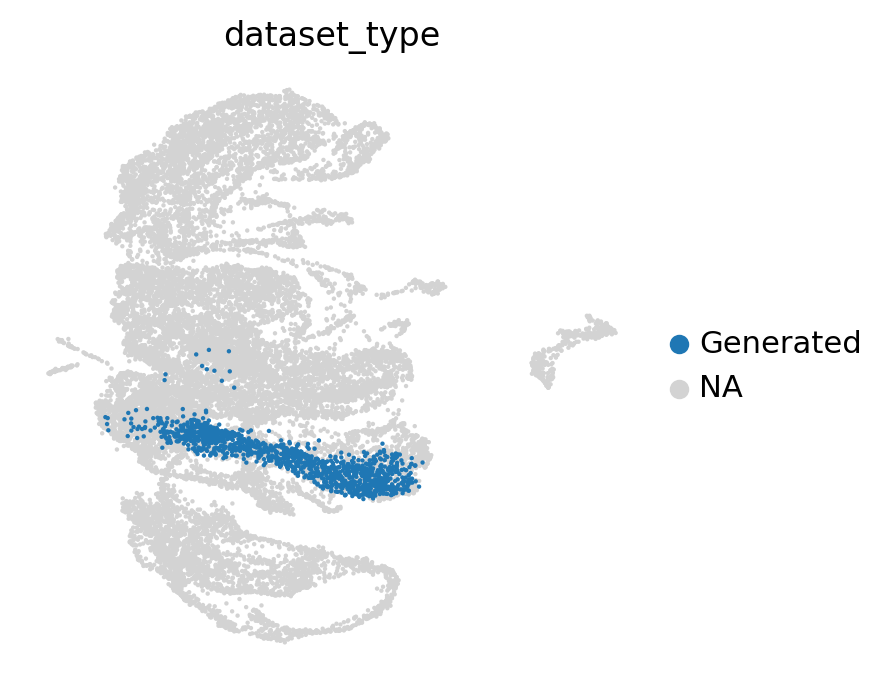

In [109]:
sc.pl.umap(adata_merged_cell_type[adata_merged_cell_type.obs.dataset_type=="Real"], color="batch")
sc.pl.umap(adata_merged_cell_type[adata_merged_cell_type.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged_cell_type, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - batch

In [110]:
# Pick condition 
covariates_batch = 'Waterston_500_minutes_batch_2'

condition_id_batch = dataset.id2cov["batch"][covariates_batch]

adata_cond = adata_original[adata_original.obs.batch==covariates_batch]
n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_clus*torch.ones(n_to_generate).long(), 
           "batch": condition_id_batch*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_type for n in range(n_to_generate)], 
           "batch": [covariates_batch for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [111]:
X_generated_batch = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=2, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="cell_type",
                                        conditioning_covariates=["batch"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

adata_generated_batch = sc.AnnData(X=X_generated_batch.cpu().numpy())

In [112]:
adata_merged_batch = join_real_generated(adata_original, adata_generated_batch, True, classes_str, ["cell_type", "batch"])

In [113]:
sc.pp.neighbors(adata_merged_batch)
sc.tl.umap(adata_merged_batch)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

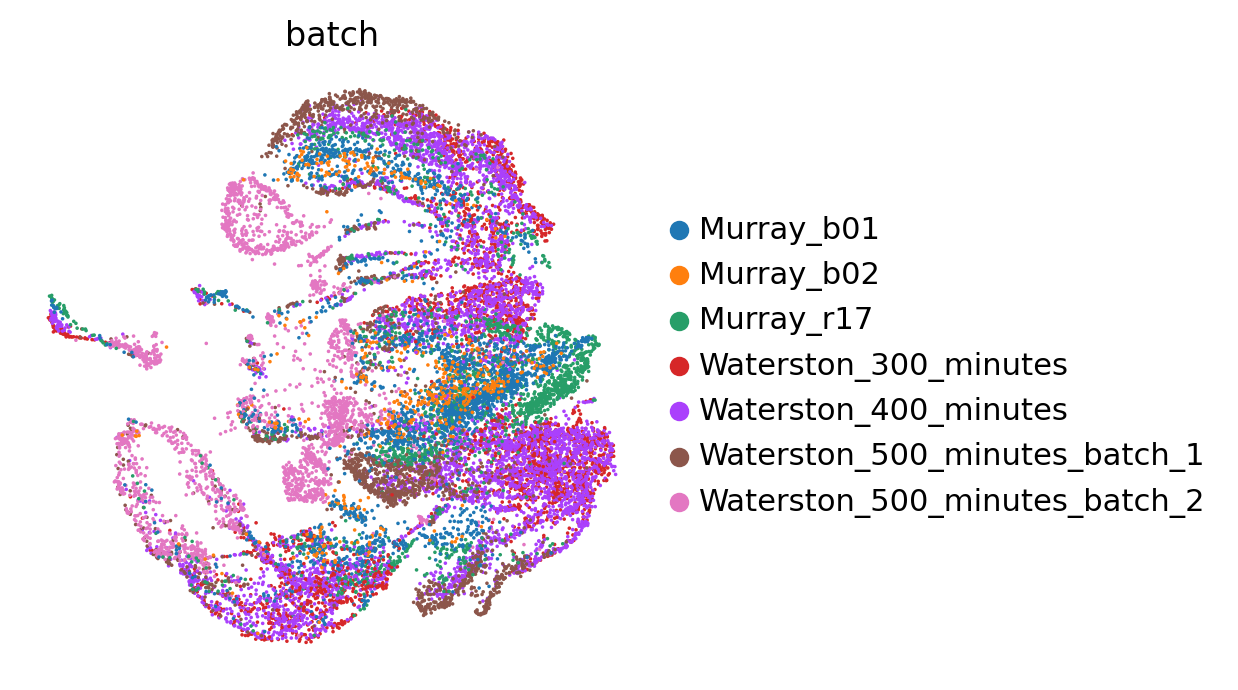

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

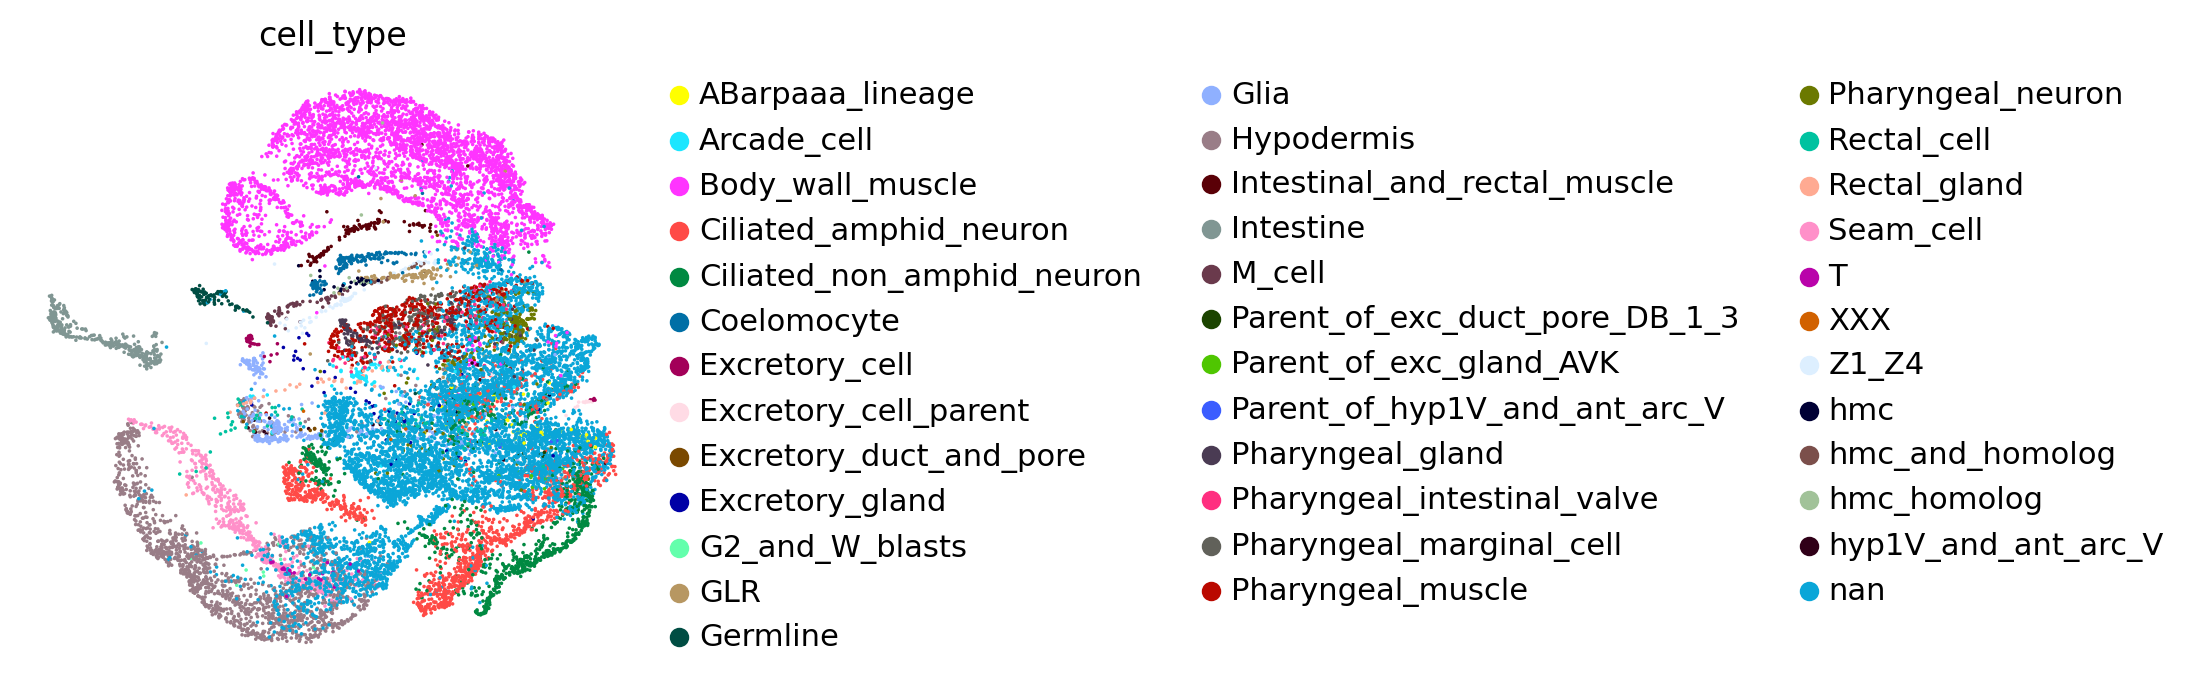

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


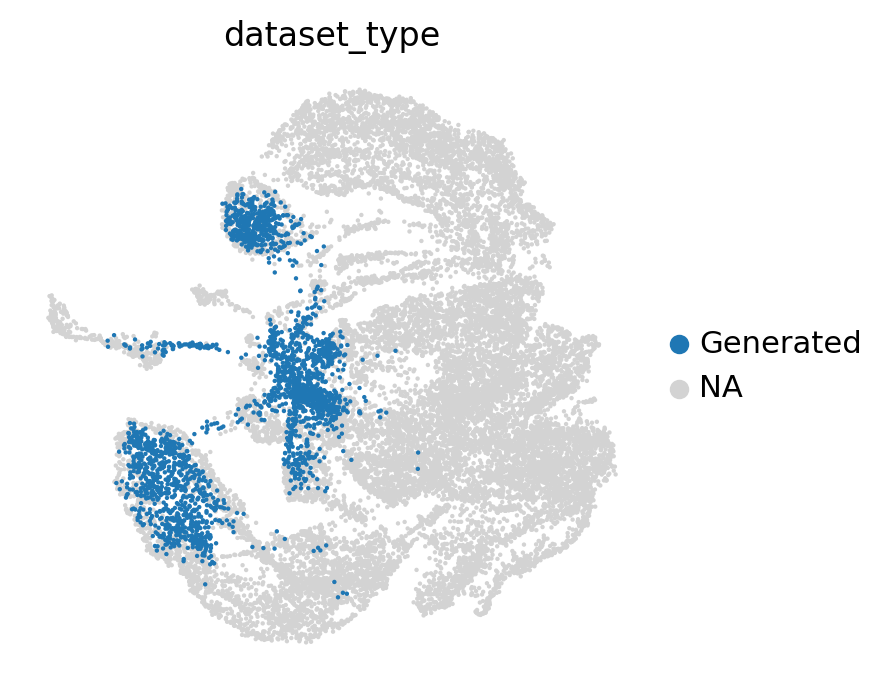

In [114]:
sc.pl.umap(adata_merged_batch[adata_merged_batch.obs.dataset_type=="Real"], color="batch")
sc.pl.umap(adata_merged_batch[adata_merged_batch.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged_batch, color="dataset_type", groups="Generated", s=10)

## UNCONDITIONAL

In [123]:
index_range

17941

In [136]:
num_indices = 17000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_cell_type_str =  list(adata_indices.obs.cell_type)
classes_cell_type = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes_cell_type_str]).cuda()

classes_batch_str =  list(adata_indices.obs.batch)
classes_batch = torch.tensor([dataset.id2cov["batch"][c] for  c in classes_batch_str]).cuda()

classes_str = {"cell_type": classes_cell_type_str,
                  "batch": classes_batch_str}


log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [137]:
X_generated_uncond = generative_model.sample(batch_size=num_indices,
                                            n_sample_steps=2, 
                                            theta_covariate="cell_type", 
                                            size_factor_covariate="cell_type",
                                            conditioning_covariates=["cell_type"],
                                            covariate_indices=None, 
                                            log_size_factor=log_size_factors, 
                                            unconditional=True)

X_generated_uncond = X_generated_uncond.to("cpu")

adata_generated_uncond = sc.AnnData(X=X_generated_uncond.cpu().numpy())

In [138]:
adata_merged_uncond = join_real_generated(adata_original, adata_generated_uncond, True, classes_str, ["cell_type", "batch"])

In [139]:
sc.pp.neighbors(adata_merged_uncond)
sc.tl.umap(adata_merged_uncond)

In [1]:
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="batch")
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged_uncond, color="dataset_type", groups="Generated", s=10)

NameError: name 'sc' is not defined